Make the error plots and the parity plots

In [1]:
import pdb
import copy
from collections import defaultdict, OrderedDict
import random
from pprint import pprint
import numpy as np
import dill as pickle
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
from pymatgen.matproj.rest import MPRester
from gaspy_regress import plot
from gaspy_regress.preprocessor import GASpyPreprocessor
from gaspy import gasdb, defaults, utils

rcParams['font.sans-serif'] = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['savefig.dpi'] = 600

%matplotlib inline
%load_ext ipycache

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning:

The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



# Performance metric plot

In [2]:
%%cache residuals.pkl residuals

n_models = 16

# Pull out all of the residuals from the models
residuals = []
for n in range(n_models):
    with open('./models/model_%i.pkl' % n, 'rb') as f:
        model = pickle.load(f)
    residuals.append(model.residuals)

[Skipped the cell's code and loaded variables residuals from file '/global/project/projectdirs/m2755/manuscripts/GASpy/figures/model_info/residuals.pkl'.]


/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [3]:
# Condense the residuals into performance metrics
RMSEs = {ads: defaultdict(list) for ads in ('CO', 'H')}
MAEs = {ads: defaultdict(list) for ads in ('CO', 'H')}
MADs = {ads: defaultdict(list) for ads in ('CO', 'H')}
for model_residuals in residuals:
    for block, split_residuals in model_residuals.iteritems():
        ads = block[0]
        for dataset in ('train', 'test'):
            y_hat = split_residuals[dataset]
            y = np.zeros(y_hat.shape)
            RMSEs[ads][dataset].append(np.sqrt(metrics.mean_squared_error(y, y_hat)))
            MAEs[ads][dataset].append(metrics.mean_absolute_error(y, y_hat))
            MADs[ads][dataset].append(metrics.median_absolute_error(y, y_hat))
performance_metrics = OrderedDict()
performance_metrics['RMSE'] = RMSEs
performance_metrics['MAE'] = MAEs
performance_metrics['MAD'] = MADs

# Make a quick function to pull out averages and standard deviations
def pull_avg(metric, ads, dataset):
    return np.average(metric[ads][dataset])
def pull_std(metric, ads, dataset):
    return np.std(metric[ads][dataset])

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans



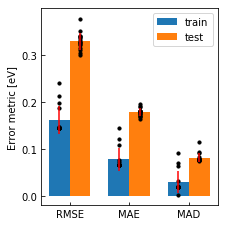

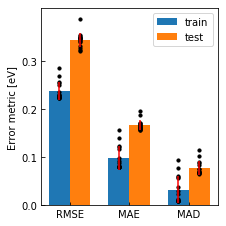

In [4]:
# Plot settings
bar_width = 0.35
fontsize = 10
figsize = (3.25, 3.25)
x_locs = np.arange(len(performance_metrics))  # x-axis locations
y_ticks = [0, 0.1, 0.2, 0.3]
dot_size = 10
ecolor = 'red'

# Make the two panels (for each adsorbate)
for i, (ads) in enumerate(('CO', 'H')):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the train and test sets in separate bars
    bars = []
    for j, dataset in enumerate(('train', 'test')):
        avgs = []
        stds = []
        # Plot the metrics as groups
        for metric_name, metric in performance_metrics.iteritems():
            avgs.append(pull_avg(metric, ads, dataset))
            stds.append(pull_std(metric, ads, dataset))
        x_plot = x_locs + j*bar_width
        bar = ax.bar(x_plot, avgs, bar_width, bottom=0,
                     yerr=stds, ecolor=ecolor, zorder=0)
        bars.append(bar)
        # Plot the distribution of data on top of the bars
        for k, metric_datasets in enumerate([RMSEs, MAEs, MADs]):
            metric_data = metric_datasets[ads][dataset]
            x_plot = np.array([k]*len(metric_data)) + j*bar_width
            ax.scatter(x_plot, metric_data, zorder=1, color='black', s=dot_size)

    # Label and format the subplots
    ax.set_xticks(x_locs + bar_width/2)
    ax.set_xticklabels(tuple(performance_metrics.keys()))
    ax.set_yticks(y_ticks)
    ax.tick_params(direction='in')
    ax.set_ylabel('Error metric [eV]')
    ax.legend(tuple(bars), ('train', 'test'))
    plt.tight_layout()
    plt.savefig('performance_metrics_%s.pdf'%(ads), transparent=True, bbox_inches='tight')

In [5]:
CO_test_rmse = np.mean(performance_metrics['RMSE']['CO']['test'])
H_test_rmse = np.mean(performance_metrics['RMSE']['H']['test'])

print('Test RMSE for CO is %.2f' % CO_test_rmse)
print('Test RMSE for H is %.2f' % H_test_rmse)

Test RMSE for CO is 0.33
Test RMSE for H is 0.35


In [6]:
CO_test_mae = np.mean(performance_metrics['MAE']['CO']['test'])
H_test_mae = np.mean(performance_metrics['MAE']['H']['test'])

print('Test MAE for CO is %.2f' % CO_test_mae)
print('Test MAE for H is %.2f' % H_test_mae)

Test MAE for CO is 0.18
Test MAE for H is 0.17


In [7]:
CO_test_mad = np.mean(performance_metrics['MAD']['CO']['test'])
H_test_mad = np.mean(performance_metrics['MAD']['H']['test'])

print('Test MAD for CO is %.2f' % CO_test_mad)
print('Test MAD for H is %.2f' % H_test_mad)

Test MAD for CO is 0.08
Test MAD for H is 0.08


# Parity plots of energy

In [8]:
# Open an example GASpyRegressor
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

## CO

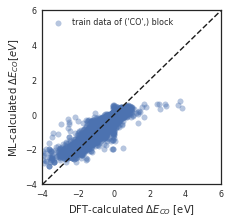

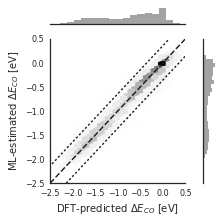

In [15]:
# Make the parity plot
dft_energies, ml_energies, _ = model.parity_plot(blocks=[('CO',)], plotter='matplotlib',
                                                 xlabel='DFT-calculated $\Delta E_{CO}$ [eV]',
                                                 ylabel='ML-calculated $\Delta E_{CO} [eV]$',
                                                 title=None, figsize=(3.2, 3.2),
                                                 fname='dE_parity_CO.pdf',
                                                 font={'size': 10})
dft_energies = dft_energies.values()[0]
ml_energies = ml_energies.values()[0]

# Hex plot is probably more useful. Let's make that instead.
lims = (-2.5, 0.5)
ticks = np.linspace(-2.5, 0.5, 7)
g = sns.jointplot(dft_energies, ml_energies, kind='hex',
                  xlim=lims, ylim=lims, color='k',
                  stat_func=None, size=3.2)
# Pull out the appropriate figure/axes so we can fine-tune
fig = g.fig
ax = fig.axes[0]
# Add parity line
ax.plot(ticks, ticks, '--k')
ax.plot(ticks+2*CO_test_mae, ticks, ':k')
ax.plot(ticks-2*CO_test_mae, ticks, ':k')
# Label correctly
ax.set_xlabel('DFT-predicted $\Delta E_{CO}$ [eV]')
ax.set_ylabel('ML-estimated $\Delta E_{CO}$ [eV]')
ax.set_xticks(ticks)
_ = ax.set_yticks(ticks)
fig.tight_layout()
fig.savefig('dE_parity_CO.pdf')

## H

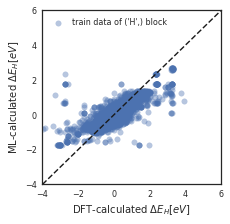

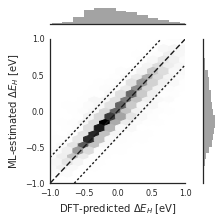

In [16]:
# Make the parity plot
dft_energies, ml_energies, _ = model.parity_plot(blocks=[('H',)], plotter='matplotlib',
                                                 xlabel='DFT-calculated $\Delta E_{H} [eV]$',
                                                 ylabel='ML-calculated $\Delta E_{H} [eV]$',
                                                 title=None, figsize=(3.2, 3.2),
                                                 fname='dE_parity_H.pdf',
                                                 font={'size': 10})
dft_energies = dft_energies.values()[0]
ml_energies = ml_energies.values()[0]

# Hex plot is probably more useful. Let's make that instead.
lims = (-1, 1)
ticks = np.linspace(-1, 1, 5)
g = sns.jointplot(dft_energies, ml_energies, kind='hex',
                  xlim=lims, ylim=lims, color='k',
                  stat_func=None, size=3.2)
# Pull out the appropriate figure/axes so we can fine-tune
fig = g.fig
ax = fig.axes[0]
# Add parity line and 95% prediction intervals
ax.plot(ticks, ticks, '--k')
ax.plot(ticks+2*CO_test_mae, ticks, ':k')
ax.plot(ticks-2*CO_test_mae, ticks, ':k')
# Label correctly
ax.set_xlabel('DFT-predicted $\Delta E_{H}$ [eV]')
ax.set_ylabel('ML-estimated $\Delta E_{H}$ [eV]')
ax.set_xticks(ticks)
_ = ax.set_yticks(ticks)
fig.tight_layout()
fig.savefig('dE_parity_H.pdf')

# Parity plots of electrocatalytic performance

In [11]:
import pdb
import seaborn as sns
sns.set(style='white', color_codes=True)

# Pull the data
with open('../CO2RR_predictions.pkl', 'rb') as f:
    co2rr_data = pickle.load(f)
with open('../HER_predictions.pkl', 'rb') as f:
    her_data = pickle.load(f)

In [12]:
def plot_hex(data, x_label, y_label, rmse,
             pi_range_lo, pi_range_hi, pi_label_loc,
             plot_range=None,
             font_size=10, figsize=3.25,
             save_name='parity.pdf', save_dpi=600):
    # Unpack the data structure
    sim_data, _ = data
    docs, predictions, estimations = zip(*sim_data)
    x_data_pred, y_data_pred = zip(*predictions)
    x_data_est, y_data_est = zip(*estimations)
    # Transform the data
    pred, pred_u = zip(*y_data_pred)
    est, est_u = zip(*y_data_est)
    pred = np.array(pred)
    est = np.array(est)
    # Set the plot range
    if not plot_range:
        plot_min = np.min(np.minimum(pred, est))
        plot_max = np.max(np.maximum(pred, est))
        plot_range = [plot_min, plot_max]
    else:
        plot_min = plot_range[0]
        plot_max = plot_range[1]

    # Scaling/font sizes
    sns.set_context('paper', rc={'font.size': font_size,
                                 'axes.titlesize': font_size,
                                 'axes.labelsize': font_size})

    # Seaborn is not yet good at making log-log jointplots with hexbin shading.
    # So we make a linear jointplot with hexbin shading, but simply put the logarithm
    # of the values in.
    plot_range = tuple(np.log10(plot_range))
    plot_min = np.log10(plot_min)
    plot_max = np.log10(plot_max)
    pred = np.log10(pred)
    est = np.log10(est)

    # Note that we also trim out points outside of the plotting range,
    # because the hex bins get all messed up if we simply "zoom in". We also convert to
    # numpy arrays because Seaborn likes them.
    pred_trimmed = []
    est_trimmed = []
    for _pred, _est in zip(pred, est):
        if plot_min < _pred < plot_max and plot_min < _est < plot_max:
            pred_trimmed.append(_pred)
            est_trimmed.append(_est)
    pred_trimmed = np.array(pred_trimmed)
    est_trimmed = np.array(est_trimmed)

    # Make the joint plot
    grid = sns.jointplot(pred_trimmed, est_trimmed, kind='hex', space=0, stat_func=None,
                         color='k', size=figsize)
    grid.set_axis_labels(x_label, y_label)
    # Add and label the parity line and the prediction interval
    grid.ax_joint.plot(plot_range, plot_range, 'k--')
    grid.ax_joint.set_xlim(plot_range)
    grid.ax_joint.set_ylim(plot_range)

    # Save & display
    plt.tight_layout()
    plt.savefig(save_name, bbox_inches='tight', dpi=save_dpi, transparent=True)

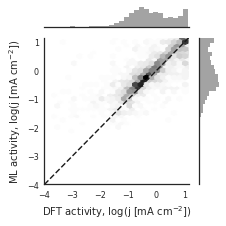

In [13]:
plot_hex(co2rr_data,
         'DFT activity, log(j [mA cm$^{-2}$])',
         'ML activity, log(j [mA cm$^{-2}$])',
         CO_test_rmse,
         pi_range_lo=(0.00003, 1.51973), pi_range_hi=(0.00030, 0.03307),
         pi_label_loc=(-2.8, -1.7),
         plot_range=[0.0001, 14], save_name='CO2RR_parity.pdf', save_dpi=600)

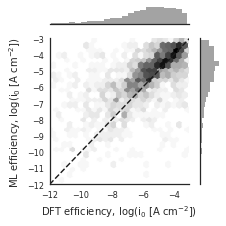

In [14]:
plot_hex(her_data, 
         'DFT efficiency, log(i$_0$ [A cm$^{-2}$])',
         'ML efficiency, log(i$_0$ [A cm$^{-2}$])',
         H_test_rmse,
         pi_range_lo=(0.00003, 1.51973), pi_range_hi=(0.00030, 0.03307),
         pi_label_loc=(-10.5, -8),
         plot_range=[1e-12, 1e-3], save_name='HER_parity.pdf', save_dpi=600)

# Learning curve

## Pull/parse data

In [5]:
# Pull all of the documents
fingerprints = defaults.fingerprints(simulated=True)
fingerprints['symbols'] = '$atoms.chemical_symbols'  # needed for preprocessor
docs = gasdb.get_docs(fingerprints=fingerprints, **defaults.doc_filters())

# Initialize a dictionary whose keys are the mpids we've studied
# and whose values are their compositions. This can be used to filter
# the documents
mpids = set(doc['mpid'] for doc in docs)
compositions_by_mpid = dict.fromkeys(mpids)
# Open up MP connection
mp_key = utils.read_rc('matproj_api_key')
with MPRester(mp_key) as mp_db:
    # Populate that dictionary, `compositions_by_mpid`
    for mpid in tqdm.tqdm(mpids):
        entry = mp_db.get_entry_by_material_id({'task_ids': mpid})
        comp = set(entry.as_dict()['composition'].keys())
        compositions_by_mpid[mpid] = set(comp)

# Define the elements to exclude from our study
excluded_elements = set(['Ca', 'Na', 'Nb', 'S', 'Se'])
# Use the `compositions_by_mpid` dictionary to identify the mpid numbers to exclude.
mpids_to_exclude = []
for mpid, comp in compositions_by_mpid.iteritems():
    if excluded_elements.intersection(comp):
        mpids_to_exclude.append(mpid)
mpids_to_exclude = set(mpids_to_exclude)

# Finally, reconstruct docs to exclude the elements
docs = [doc for doc in docs if doc['mpid'] not in mpids_to_exclude]
# Add a key to the docs that we're probably going to need
for i, doc in enumerate(docs):
    ads = doc['adsorbates'][0]
    docs[i]['adsorbate'] = ads

Starting to pull documents...




0it [00:00, ?it/s]

102it [00:00, 878.94it/s]

10361it [00:00, 1235.00it/s]

20610it [00:00, 1750.44it/s]

30755it [00:00, 2472.45it/s]

40864it [00:01, 3376.81it/s]

50974it [00:01, 4720.90it/s]

53164it [00:01, 36002.02it/s]

  0%|          | 0/1517 [00:00<?, ?it/s]

  0%|          | 1/1517 [00:00<03:49,  6.59it/s]

  0%|          | 3/1517 [00:00<03:15,  7.74it/s]

  0%|          | 5/1517 [00:00<02:52,  8.79it/s]

  0%|          | 7/1517 [00:00<02:34,  9.80it/s]

  1%|          | 9/1517 [00:00<02:28, 10.16it/s]

  1%|          | 11/1517 [00:00<02:18, 10.84it/s]

  1%|          | 13/1517 [00:01<02:15, 11.10it/s]

  1%|          | 15/1517 [00:01<02:12, 11.34it/s]

  1%|          | 17/1517 [00:01<02:11, 11.38it/s]

  1%|▏         | 19/1517 [00:01<02:07, 11.78it/s]

  1%|▏         | 21/1517 [00:01<02:12, 11.32it/s]

  2%|▏         | 23/1517 [00:01<02:08, 11.67it/s]


  2%|▏         | 25/1517 [00:07<20:53,  1.19it/s]

  2%|▏         | 26/1517 [00:07<15:27,  1.61it/s]

  2%|▏         | 2

 16%|█▋        | 247/1517 [00:38<17:46,  1.19it/s]

 16%|█▋        | 249/1517 [00:38<12:55,  1.64it/s]

 17%|█▋        | 251/1517 [00:38<09:30,  2.22it/s]

 17%|█▋        | 253/1517 [00:38<07:09,  2.94it/s]

 17%|█▋        | 255/1517 [00:39<05:34,  3.77it/s]

 17%|█▋        | 257/1517 [00:39<04:24,  4.77it/s]

 17%|█▋        | 259/1517 [00:39<03:34,  5.86it/s]

 17%|█▋        | 261/1517 [00:39<03:00,  6.96it/s]

 17%|█▋        | 263/1517 [00:39<02:40,  7.82it/s]

 17%|█▋        | 265/1517 [00:39<02:35,  8.03it/s]

 18%|█▊        | 267/1517 [00:40<02:20,  8.92it/s]

 18%|█▊        | 269/1517 [00:40<02:14,  9.30it/s]

 18%|█▊        | 271/1517 [00:40<02:03, 10.09it/s]

 18%|█▊        | 273/1517 [00:40<01:55, 10.73it/s]

 18%|█▊        | 275/1517 [00:40<01:51, 11.14it/s]

 18%|█▊        | 277/1517 [00:40<01:53, 10.97it/s]

 18%|█▊        | 279/1517 [00:41<01:50, 11.19it/s]

 19%|█▊        | 281/1517 [00:41<02:01, 10.21it/s]

 19%|█▊        | 283/1517 [00:41<02:04,  9.94it/s]

 19%|█▉     

 35%|███▍      | 528/1517 [01:03<02:15,  7.28it/s]

 35%|███▍      | 529/1517 [01:03<02:36,  6.32it/s]

 35%|███▍      | 530/1517 [01:03<02:24,  6.85it/s]

 35%|███▌      | 531/1517 [01:04<02:24,  6.84it/s]

 35%|███▌      | 532/1517 [01:04<02:19,  7.08it/s]

 35%|███▌      | 533/1517 [01:04<02:15,  7.26it/s]

 35%|███▌      | 534/1517 [01:04<02:08,  7.67it/s]

 35%|███▌      | 535/1517 [01:04<03:15,  5.01it/s]

 35%|███▌      | 537/1517 [01:04<02:40,  6.12it/s]

 35%|███▌      | 538/1517 [01:05<04:22,  3.73it/s]

 36%|███▌      | 540/1517 [01:05<03:27,  4.70it/s]

 36%|███▌      | 542/1517 [01:05<02:50,  5.72it/s]

 36%|███▌      | 544/1517 [01:05<02:25,  6.67it/s]

 36%|███▌      | 546/1517 [01:06<02:06,  7.70it/s]

 36%|███▌      | 548/1517 [01:06<02:22,  6.78it/s]

 36%|███▌      | 549/1517 [01:06<02:17,  7.03it/s]

 36%|███▋      | 550/1517 [01:06<02:07,  7.61it/s]

 36%|███▋      | 551/1517 [01:06<01:58,  8.17it/s]

 36%|███▋      | 553/1517 [01:06<01:48,  8.86it/s]

 37%|███▋   

 52%|█████▏    | 793/1517 [01:30<01:04, 11.19it/s]

 52%|█████▏    | 795/1517 [01:30<01:03, 11.33it/s]

 53%|█████▎    | 797/1517 [01:30<01:01, 11.75it/s]

 53%|█████▎    | 799/1517 [01:30<01:02, 11.54it/s]

 53%|█████▎    | 801/1517 [01:30<01:09, 10.27it/s]

 53%|█████▎    | 803/1517 [01:30<01:06, 10.74it/s]

 53%|█████▎    | 805/1517 [01:31<01:05, 10.84it/s]

 53%|█████▎    | 807/1517 [01:31<01:01, 11.45it/s]

 53%|█████▎    | 809/1517 [01:31<00:59, 11.85it/s]

 53%|█████▎    | 811/1517 [01:31<00:58, 11.98it/s]

 54%|█████▎    | 813/1517 [01:31<00:57, 12.24it/s]

 54%|█████▎    | 815/1517 [01:31<00:58, 12.09it/s]

 54%|█████▍    | 817/1517 [01:32<00:56, 12.33it/s]

 54%|█████▍    | 819/1517 [01:32<00:56, 12.29it/s]

 54%|█████▍    | 821/1517 [01:32<00:56, 12.38it/s]

 54%|█████▍    | 823/1517 [01:32<00:54, 12.69it/s]

 54%|█████▍    | 825/1517 [01:32<00:54, 12.61it/s]

 55%|█████▍    | 827/1517 [01:32<00:54, 12.57it/s]

 55%|█████▍    | 829/1517 [01:33<00:57, 11.89it/s]

 55%|█████▍ 

 71%|███████   | 1073/1517 [01:54<01:01,  7.22it/s]

 71%|███████   | 1074/1517 [01:55<00:58,  7.52it/s]

 71%|███████   | 1075/1517 [01:55<01:23,  5.30it/s]

 71%|███████   | 1077/1517 [01:55<01:09,  6.36it/s]

 71%|███████   | 1079/1517 [01:55<00:58,  7.52it/s]

 71%|███████▏  | 1081/1517 [01:56<01:12,  6.03it/s]

 71%|███████▏  | 1083/1517 [01:56<01:00,  7.16it/s]

 72%|███████▏  | 1085/1517 [01:56<00:54,  7.90it/s]

 72%|███████▏  | 1086/1517 [01:56<01:10,  6.11it/s]

 72%|███████▏  | 1087/1517 [01:56<01:03,  6.75it/s]

 72%|███████▏  | 1088/1517 [01:57<01:21,  5.27it/s]

 72%|███████▏  | 1090/1517 [01:57<01:06,  6.43it/s]

 72%|███████▏  | 1092/1517 [01:57<00:57,  7.34it/s]

 72%|███████▏  | 1093/1517 [01:57<00:55,  7.57it/s]

 72%|███████▏  | 1094/1517 [01:57<00:59,  7.14it/s]

 72%|███████▏  | 1095/1517 [01:57<00:57,  7.29it/s]

 72%|███████▏  | 1097/1517 [01:58<00:50,  8.32it/s]

 72%|███████▏  | 1099/1517 [01:58<00:45,  9.28it/s]

 73%|███████▎  | 1101/1517 [01:58<01:17,  5.39

 88%|████████▊ | 1338/1517 [02:19<00:13, 13.07it/s]

 88%|████████▊ | 1340/1517 [02:19<00:13, 13.14it/s]

 88%|████████▊ | 1342/1517 [02:19<00:13, 12.50it/s]

 89%|████████▊ | 1344/1517 [02:20<00:13, 12.89it/s]

 89%|████████▊ | 1346/1517 [02:20<00:13, 12.78it/s]

 89%|████████▉ | 1348/1517 [02:20<00:13, 12.21it/s]

 89%|████████▉ | 1350/1517 [02:20<00:13, 12.47it/s]

 89%|████████▉ | 1352/1517 [02:20<00:13, 12.68it/s]

 89%|████████▉ | 1354/1517 [02:20<00:13, 12.39it/s]

 89%|████████▉ | 1356/1517 [02:21<00:13, 12.05it/s]

 90%|████████▉ | 1358/1517 [02:21<00:13, 11.95it/s]

 90%|████████▉ | 1360/1517 [02:21<00:12, 12.36it/s]

 90%|████████▉ | 1362/1517 [02:21<00:12, 12.36it/s]

 90%|████████▉ | 1364/1517 [02:21<00:12, 12.72it/s]

 90%|█████████ | 1366/1517 [02:21<00:11, 12.74it/s]

 90%|█████████ | 1368/1517 [02:22<00:11, 12.52it/s]

 90%|█████████ | 1370/1517 [02:22<00:11, 12.47it/s]

 90%|█████████ | 1372/1517 [02:22<00:11, 12.74it/s]

 91%|█████████ | 1374/1517 [02:22<00:11, 12.60

## Perform regressions

In [4]:
# Regression settings
features = ['coordatoms_chemfp0', 'neighbors_chemfp0']
dim_red = 'pca'
responses = ['energy']
blocks = ['adsorbate']
fit_blocks = [('CO',), ('H',)]
adsorbates = ['CO', 'H']
# Pull data only with these VASP settings
VASP_SETTINGS = utils.vasp_settings_to_str({'gga': 'RP',
                                            'pp_version': '5.4',
                                            'encut': 350})

In [2]:
%%cache errors.pkl dfs

# Decide how big the smallest model will be
min_train_size = 200
# How many models to make for each curve
n_models = 20

# Pull out the correct adsorbate data and initialize the output dataframes
dfs = dict.fromkeys(adsorbates)
for ads in adsorbates:
    ads_docs = [doc for doc in docs if ads == doc['adsorbate']]

    # Calculate the training sizes and subsequent split sizes
    training_sizes = np.linspace(min_train_size, len(ads_docs)-min_train_size, n_models)
    training_fractions = training_sizes / len(ads_docs)

    # We'll eventually be storing the data in a Pandas dataframe.
    # Here we initialize the dictionary that'll be used to construct the dataframe
    data = defaultdict(list)

    # Make a model for each training size
    for train_size, train_frac in zip(training_sizes, training_fractions):
        docs_train, docs_test = train_test_split(ads_docs, train_size=train_frac)

        # If we've already done this point, just open it
        try:
            with open('learning_curve_models/%s_%i.pkl' % (ads, train_size), 'rb') as f_handle:
                pp, tpot, train_errors, test_errors = pickle.load(f_handle)
            y_train_pred = train_errors
            y_train = np.zeros(len(y_train_pred))
            y_test_pred = test_errors
            y_test = np.zeros(len(y_test_pred))

        # Otherwise fit the regressor and save it
        except IOError:
            raise
            # Initialize the preprocessing pipeline
            pp = GASpyPreprocessor(docs=docs_train, features=features, dim_red=dim_red)
            tpot = TPOTRegressor(
                                 generations=1,
                                 population_size=16,
                                 offspring_size=16,
                                 verbosity=2,
                                 #random_state=42,
                                 scoring='neg_median_absolute_error',
                                 #scoring='neg_mean_absolute_error',
                                 #scoring='neg_mean_squared_error',
                                 n_jobs=16,
                                )
            # Establish the training data and then train
            x_train = pp.transform(docs_train)
            x_test = pp.transform(docs_test)
            y_train = np.array([doc['energy'] for doc in docs_train])
            y_test = np.array([doc['energy'] for doc in docs_test])
            tpot.fit(x_train, y_train)
            # Make predictions then calculate errors
            y_train_pred = tpot.predict(x_train)
            y_test_pred = tpot.predict(x_test)
            train_errors = y_train_pred - y_train
            test_errors = y_test_pred - y_test
            # Pickle the preprocessor, model, and errors
            tpot = tpot.fitted_pipeline_
            with open('learning_curve_models/%s_%i.pkl'
                      % (ads, train_size), 'wb') as f_handle:
                pickle.dump((pp, tpot, train_errors, test_errors), f_handle)

        # Calculate error metrics
        train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
        train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
        train_mad = metrics.median_absolute_error(y_train, y_train_pred)
        test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
        test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
        test_mad = metrics.median_absolute_error(y_test, y_test_pred)
        # Store the performance metrics
        data['Training Size'].append(len(docs_train))
        data['Train RMSE'].append(train_rmse)
        data['Train MAE'].append(train_mae)
        data['Train MAD'].append(train_mad)
        data['Test RMSE'].append(test_rmse)
        data['Test MAE'].append(test_mae)
        data['Test MAD'].append(test_mad)
    # Create the dataframe
    dfs[ads] = pd.DataFrame(data)

[Skipped the cell's code and loaded variables dfs from file '/global/project/projectdirs/m2755/manuscripts/GASpy/SI/surrogate_info/errors.pkl'.]


# Plot

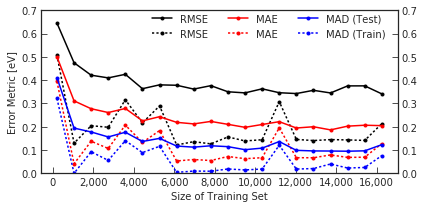

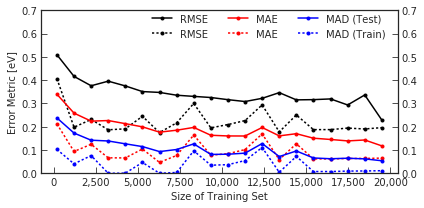

In [23]:
# Plot settings
figsize = (6, 3)
ylim = (0, 0.7)
yticks = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
xticks = [0, 5000, 10000, 15000, 20000]
sns.set_style('ticks')

# Make a plot for each adsorbate
for ads in adsorbates:
    df = dfs[ads]
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

    # Create the learning curves
    _ = plt.plot('Training Size', 'Test RMSE', data=df,
                 color='k', linestyle='-', marker='.')
    _ = plt.plot('Training Size', 'Train RMSE', data=df,
                 color='k', linestyle=':', marker='.')
    _ = plt.plot('Training Size', 'Test MAE', data=df,
                 color='r', linestyle='-', marker='.')
    _ = plt.plot('Training Size', 'Train MAE', data=df,
                 color='r', linestyle=':', marker='.')
    _ = plt.plot('Training Size', 'Test MAD', data=df,
                 color='b', linestyle='-', marker='.')
    _ = plt.plot('Training Size', 'Train MAD', data=df,
                 color='b', linestyle=':', marker='.')

    # Format
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_ylabel('Error Metric [eV]')
    ax.tick_params(labelright=True, direction='in')
    y_axis = ax.get_yaxis()
    y_axis.set_ticks_position('both')
    plt.legend(['RMSE', 'RMSE', 'MAE', 'MAE', 'MAD (Test)', 'MAD (Train)'],
               ncol=3, loc=(0.3, 0.8))
    ax.set_xlabel('Size of Training Set')
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    #ax.set_xticks(xticks)

    # Save
    plt.tight_layout()
    plt.savefig('learning_curve_for_%s.pdf' % ads, transparent=True)